## Mount Google Drive


In [ ]:
import os
import sys
from google.colab import drive

# Change according to your google drive's file path
workdir = "/content/drive/MyDrive/Internship/Diabetes(NSTEMI)/Development"

try:
    # Mount Drive
    drive.mount('/content/drive', force_remount=True) # Make sure it remounts even if already mounted

    # Change Current Directory
    os.chdir(workdir)
    print("Current Working Directory: ", os.getcwd()) # Show current directory path

except Exception as e:
    print("Error: Failed to Mount Google Drive : ", e)

Mounted at /content/drive
Current Working Directory:  /content/drive/MyDrive/Internship/Diabetes(NSTEMI)/Development


## Import Library

In [ ]:
import pandas as pd # work with tabular data
import numpy as np # numerical operations and arrays
import matplotlib.pyplot as plt #  creating plots and charts.
import seaborn as sns # makes statistical plots look nicer and easier
import joblib # save and load models
from sklearn.experimental import enable_iterative_imputer # IterativeImputer is considered experimental, need to turn on to use
from sklearn.impute import SimpleImputer # use to fill missing values
from sklearn.impute import IterativeImputer # use machine learning to guess missing values
from sklearn.preprocessing import StandardScaler # standardize data

# showing warning when change a column's data type
pd.set_option('future.no_silent_downcasting', True)

## Load Data

In [ ]:
# Load All Raw Data (Took about 10 minutes with Google Drive)
data_1 = pd.read_excel('../../Dataset/raw/06-10.xlsx')
data_2 = pd.read_excel('../../Dataset/raw/11-13.xlsx')
data_3 = pd.read_excel('../../Dataset/raw/14-15.xlsx')
data_4 = pd.read_csv('../../Dataset/raw/16-17.csv', low_memory=False) # CSV can be large, need to tell pandas read the entire file before deciding column data types, use more memory if needed
data_5 = pd.read_excel('../../Dataset/raw/18-19.xlsx')
data_6 = pd.read_excel('../../Dataset/raw/20-21.xlsx')

In [ ]:
# Create copy (Wont have to load the raw data again if messed up halfway)
data1 = data_1.copy(deep=True) # deep=True: fully independent duplicate
data2 = data_2.copy(deep=True)
data3 = data_3.copy(deep=True)
data4 = data_4.copy(deep=True)
data5 = data_5.copy(deep=True)
data6 = data_6.copy(deep=True)

## Data Cleaning

In [ ]:
# Separating 2018 and 2019 (2019 will be used for calibration)

# Ensure the column is in datetime format
data5['dateadmission'] = pd.to_datetime(data5['dateadmission'])

# Create subsets
data5_2018 = data5[data5['dateadmission'].dt.year == 2018] # include only rows with year in dataadminission is 2018
data5_2019 = data5[data5['dateadmission'].dt.year == 2019] # include only rows with year in dataadminission is 2019

In [ ]:
# Reclassify data3 outcome (Only in data3 is different)
data3['ptoutcome']=data3['ptoutcome'].replace({1:"Alive",2:"Death",3:"Discharge",8888:9999})

## Temporal Split
1. Training Data - 2006 - 2018
2. Calibration Data - 2019
3. Testing Data - 2020 - 2021

In [ ]:
# Combine datasets
training_data = pd.concat([data1, data2, data3, data4, data5_2018], axis=0) # concat: stack all data
calibration_data = pd.concat ([data5_2019])
testing_data = pd.concat([data6], axis=0)

In [ ]:
# Select Features
selected_features =['ptageatnotification','ptrace','smokingstatus','killipclass','fbstatus', 'acsstratum','ptsex', 'cdys', 'cdm','chpt', 'cpremcvd', 'cmi',
                    'ccap','canginamt2wk', 'canginapast2wk', 'cheartfail', 'clung', 'crenal','ccerebrovascular', 'cpvascular','ecgabnormtypestelev1', 'ecgabnormtypestelev2',
                    'ecgabnormtypestdep','ecgabnormtypetwave', 'ecgabnormtypebbb','ecgabnormlocationil','ecgabnormlocational', 'ecgabnormlocationll', 'ecgabnormlocationtp',
                    'ecgabnormlocationrv', 'cardiaccath', 'pci','cabg', 'asa','gpri', 'heparin', 'lmwh', 'bb', 'acei', 'arb', 'statin', 'lipidla','diuretic',
                    'calcantagonist', 'oralhypogly', 'insulin', 'antiarr','heartrate', 'bpsys', 'bpdias','ck', 'tc', 'hdlc', 'ldlc', 'tg', 'fbg',
                    'timiscorenstemi','ptoutcome']

training_data = training_data[selected_features]
testing_data = testing_data[selected_features]
calibration_data = calibration_data[selected_features]

In [ ]:
# Clean rows that are totally empty (happens after selecting features)
training_data.dropna(how='all', inplace=True) # how='all': drop raw if all values are missing, inplace=True: modifies the data directly
testing_data.dropna(how='all', inplace=True)
calibration_data.dropna(how='all', inplace=True)

## Data Preprocessing

In [ ]:
# FUNCTION
# This function processes dataset by:
# - Recoding categorical variables into numerical (Can check lookups.xlsx).
# - Replacing missing value with a common value 9999 and finally change it to NULL.
# - Converting boolean and binary features to 0/1.
# - Handling some outliers
# - Ensuring all features are in a consistent and analyzable format.

def process_data (data):

  # 1 Malay, 2 Chinese, 3 Indian, 4 Others
  data['ptrace']=data['ptrace'].replace({'Malay':1,"Chinese":2,"Indian":3}) # Malay replaced with 1
  data.loc[~data['ptrace'].isin([1, 2, 3]), 'ptrace'] = 4 # ~: NOT # use loc when dont know exactly replcaement ie. others

  # 1 Never, 2 Formal, 3 Current, 9999 Not Available
  data['smokingstatus']=data['smokingstatus'].replace({'Current (any tobacco use within last 30 days)':3,"Former (quit > 30 days)":2,"Never":1, "Missing":9999,'Not available': 9999})
  data.loc[~data['smokingstatus'].isin([3,2,1,9999]), 'smokingstatus'] = 9999

  # 1 Class I, 2 Class II, 3 Class III, 4 Class IV
  data['killipclass']=data['killipclass'].replace({"I":1,"II":2,"III":3,"IV":4})
  data.loc[~data['killipclass'].isin([1,2,3,4]), 'killipclass'] = 9999

  # 0 No, 1 Yes
  data['fbstatus']=data['fbstatus'].replace({"Given at another centre prior to transfer here":1,"Given at this centre":1,"Not given-Contraindicated":3,"Not given-Missed thrombolysis":3,
                                            "Not given-patient refusal":3,"Not given-proceeded directly to primary angioplasty":3,"Not given-Missed thrombolysis":3})
  data['fbstatus']=data['fbstatus'].replace({2:1,3:3,4:3,5:3,6:3})
  data['fbstatus']=data['fbstatus'].replace({1:1,3:0})
  data.loc[~data['fbstatus'].isin([0,1]), 'fbstatus'] = 9999

  # 1 STEMI, 2 NSTEMI, 3 UA
  data['acsstratum']=data['acsstratum'].replace({"STEMI":1,"NSTEMI":2,"UA":3})
  data.loc[~data['acsstratum'].isin([1,2,3]), 'acsstratum'] = 9999

  # 1 Male, 2 Female
  data['ptsex']=data['ptsex'].replace({"Male":1,"Female":2})
  data.loc[~data['ptsex'].isin([1,2]), 'ptsex'] = 9999

  # 0 No, 1 Yes
  features = ['cdys', 'cdm','chpt', 'cpremcvd', 'cmi', 'ccap','canginamt2wk', 'canginapast2wk', 'cheartfail', 'clung', 'crenal','ccerebrovascular', 'cpvascular']
  data[features]=data[features].replace({"Yes":1,"No":2})
  data[features]=data[features].replace({1:1,2:0})
  for feature in features:
      data.loc[~data[feature].isin([0, 1]), feature] = 9999

  # 0 No, 1 Yes
  data['cardiaccath']=data['cardiaccath'].replace({"Yes":1,"No":2,"No - Transferred to another centre":2})
  data['cardiaccath']=data['cardiaccath'].replace({1:1,2:0})

  data.loc[~data['cardiaccath'].isin([0, 1]), 'cardiaccath'] = 9999

  # 0 No, 1 Yes
  features = ['cardiaccath', 'pci','cabg', 'asa','gpri', 'heparin', 'lmwh', 'bb', 'acei', 'arb', 'statin', 'lipidla','diuretic','calcantagonist', 'oralhypogly', 'insulin', 'antiarr']
  data[features]=data[features].replace({"Yes":1,"No":2})
  data[features]=data[features].replace({1:1,2:0})
  for feature in features:
      data.loc[~data[feature].isin([0, 1]), feature] = 9999

  # From true false to 0,1
  features = ['ecgabnormtypestelev1', 'ecgabnormtypestelev2', 'ecgabnormtypestdep','ecgabnormtypetwave', 'ecgabnormtypebbb','ecgabnormlocationil','ecgabnormlocational',
              'ecgabnormlocationll', 'ecgabnormlocationtp','ecgabnormlocationrv']
  data[features]=data[features].replace({'TRUE': 1, 'FALSE': 0, True: 1, False: 0})

  # Handling outliers
  # Continuous features
  data.loc[(data['heartrate'] < 0) | (data['heartrate'] > 200), 'heartrate'] = 9999 # |: or
  data.loc[(data['bpsys'] < 0) | (data['bpsys'] > 270), 'bpsys'] = 9999
  data.loc[(data['bpdias'] < 0) | (data['bpdias'] > 170), 'bpdias'] = 9999
  data.loc[(data['tc'] < 0) | (data['tc'] > 12), 'tc'] = 9999
  data.loc[(data['ck'] < 0) | (data['ck'] >10000), 'ck'] = 9999
  data.loc[(data['hdlc'] < 0) | (data['hdlc'] > 4), 'hdlc'] = 9999
  data.loc[(data['ldlc'] < 0) | (data['ldlc'] > 12), 'ldlc'] = 9999
  data.loc[(data['tg'] < 0) | (data['tg'] > 15), 'tg'] = 9999
  data.loc[(data['fbg'] < 0) | (data['fbg'] > 50), 'fbg'] = 9999

  features = ['heartrate', 'bpsys', 'bpdias','ck', 'tc', 'hdlc', 'ldlc', 'tg', 'fbg']
  for feature in features:
      data[feature] = data[feature].fillna(9999)

  # Replace invalid timi scores values with 9999
  data.loc[~data['timiscorenstemi'].isin([0,1,2,3,4,5,6]), 'timiscorenstemi'] = 9999

  # Fill missing (NaN) values with 9999
  data['timiscorenstemi'] = data['timiscorenstemi'].fillna(9999)

  # 1 death, 0 alive
  data['ptoutcome']=data['ptoutcome'].replace({"Alive":1,"Death":2,"Discharge":1,"Transferred to other hospital":1})
  data['ptoutcome']=data['ptoutcome'].replace({1:1,2:2,3:1})
  data['ptoutcome']=data['ptoutcome'].replace({1:0,2:1})
  data.loc[~data['ptoutcome'].isin([0,1]), 'ptoutcome'] = 9999

  # Locate Null Values
  data = data.replace(9999, np.nan) # replace 9999 with NaN

  print(f"Data processed successfully.")
  return data

In [ ]:
# process all data
training_data = process_data(training_data)
testing_data = process_data(testing_data)
calibration_data = process_data(calibration_data)

Data processed successfully.
Data processed successfully.
Data processed successfully.


## Get Diabetic Patient + NSTEMI only

In [ ]:
# Filter NSTEMI (acsstratum 2) AND Diabetes (cdm == 1)
training_data = training_data[(training_data['acsstratum'].isin([2])) & (training_data['cdm'] == 1)]
testing_data = testing_data[(testing_data['acsstratum'].isin([2])) & (testing_data['cdm'] == 1)]
calibration_data = calibration_data[(calibration_data['acsstratum'].isin([2])) & (calibration_data['cdm'] == 1)]

# Drop the filtering columns after filtering
cols_to_drop = ['acsstratum', 'cdm']
training_data.drop(columns=cols_to_drop)
testing_data.drop(columns=cols_to_drop)
calibration_data.drop(columns=cols_to_drop)

,ptageatnotification,ptrace,smokingstatus,killipclass,fbstatus,ptsex,cdys,chpt,cpremcvd,cmi,...,bpsys,bpdias,ck,tc,hdlc,ldlc,tg,fbg,timiscorenstemi,ptoutcome
10803,60.590000,1,1,NaN,NaN,2,1,1,0,0,...,154.0,97.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0
10804,72.300003,1,1,NaN,NaN,2,1,1,0,1,...,121.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0
10805,56.790001,1,NaN,1,NaN,1,1,1,NaN,NaN,...,160.0,70.0,130.0,4.9,0.8,2.6,2.9,NaN,4.0,0
10813,42.040001,1,3,NaN,NaN,1,0,0,0,0,...,139.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
10818,60.970001,4,1,1,NaN,1,1,1,0,0,...,139.0,79.0,596.0,NaN,NaN,NaN,NaN,NaN,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20578,56.900002,4,1,NaN,NaN,1,1,1,0,0,...,141.0,89.0,NaN,4.4,1.1,2.7,1.4,11.1,2.0,0
20580,65.190002,3,3,NaN,NaN,1,1,1,0,0,...,232.0,97.0,NaN,2.7,0.6,1.5,1.2,4.4,2.0,0
20588,53.540001,4,1,1,NaN,1,0,0,0,1,...,118.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
20593,81.059998,1,1,1,NaN,1,1,1,1,1,...,108.0,72.0,548.0,NaN,NaN,NaN,NaN,NaN,6.0,0


In [ ]:
# Get shape of each dataset
print(f"Training Data: {training_data.shape}")
print(f"Testing Data: {testing_data.shape}")
print(f"Calibration Data: {calibration_data.shape}")

Training Data: (12844, 58)
Testing Data: (2393, 58)
Calibration Data: (1621, 58)


## Handling Missing Data

In [ ]:
# Drop all rows with missing outcome
training_data = training_data.dropna(subset=['ptoutcome'])
testing_data = testing_data.dropna(subset=['ptoutcome'])
calibration_data = calibration_data.dropna(subset=['ptoutcome'])

In [ ]:
# Calculate missing percentage for each column
missing_percent = (training_data.isnull().mean() * 100).round(2) # 2 decimal places
missing_table = missing_percent[missing_percent > 0].sort_values(ascending=False).to_frame(name='Missing (%)')

# Display the table
display(missing_table)

,Missing (%)
fbstatus,99.97
fbg,34.18
oralhypogly,33.53
tg,33.50
hdlc,32.60
ldlc,32.16
tc,32.15
killipclass,30.23
ck,23.84
cpremcvd,22.59


/tmp/ipython-input-2777435443.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


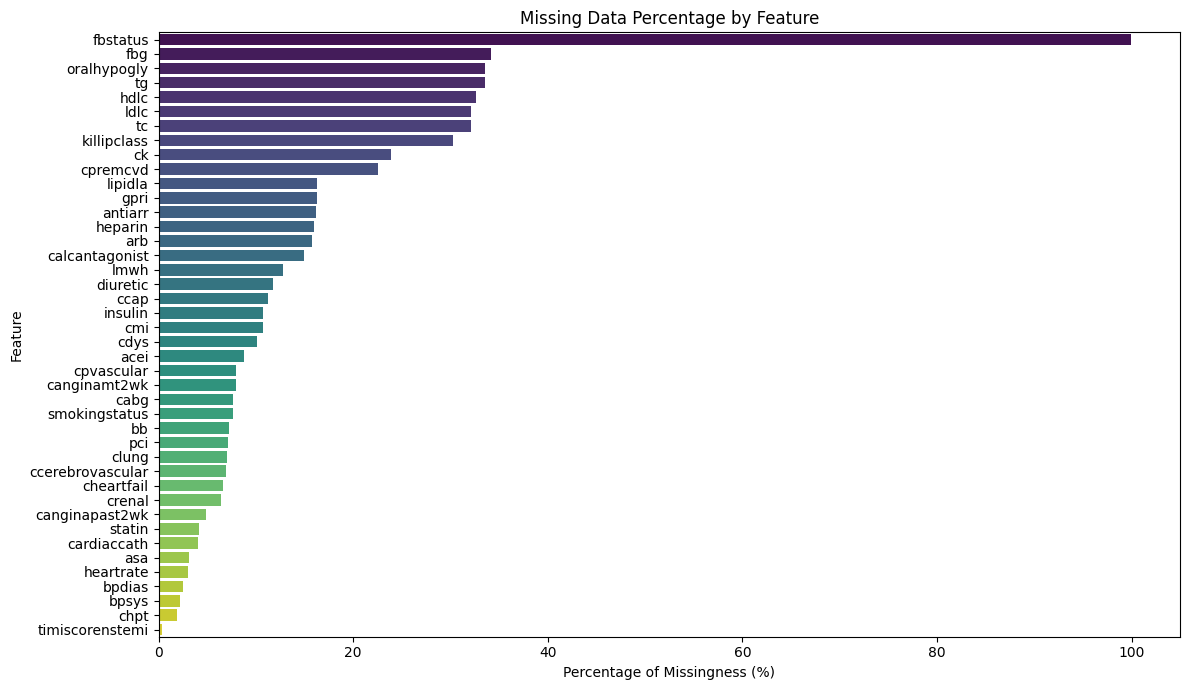

In [ ]:
# Visualize Data Missingness
plt.figure(figsize=(12, 7)) # width=12 inches, height=7 inches
sns.barplot(
    y=missing_table.index,
    x=missing_table['Missing (%)'],
    palette="viridis"
)
plt.xlabel('Percentage of Missingness (%)')
plt.ylabel('Feature')
plt.title('Missing Data Percentage by Feature')
plt.tight_layout() # adjusts spacing so labels don’t overlap
plt.show()

In [ ]:
# Assign Data Types
binary_columns = ['fbstatus', 'cdys', 'chpt', 'cpremcvd', 'cmi', 'ccap','canginamt2wk',
                      'canginapast2wk', 'cheartfail', 'clung', 'crenal', 'ccerebrovascular', 'cpvascular', 'ecgabnormtypestelev1',
                      'ecgabnormtypestelev2', 'ecgabnormtypestdep', 'ecgabnormtypetwave', 'ecgabnormtypebbb', 'ecgabnormlocationil',
                      'ecgabnormlocational', 'ecgabnormlocationll', 'ecgabnormlocationtp', 'ecgabnormlocationrv', 'cardiaccath',
                      'pci', 'cabg', 'asa', 'gpri', 'heparin', 'lmwh', 'bb', 'acei', 'arb', 'statin', 'lipidla', 'diuretic',
                      'calcantagonist', 'oralhypogly', 'insulin', 'antiarr']
categorical_columns = ['ptrace', 'ptsex']
continuous_columns = ['ptageatnotification','heartrate', 'bpsys', 'bpdias', 'ck', 'tc', 'hdlc', 'ldlc', 'tg', 'fbg']
ordinal_columns = ['killipclass','smokingstatus' ] # have a meaningful order/ranking
timi_columns = ['timiscorestemi', 'timiscorenstemi']

In [ ]:
# Mode imputation for binary and categorical columns
mode_imputer = SimpleImputer(strategy='most_frequent') # replace missing values in a column with the most frequent value of the column

# Fit and transform on training data
training_data[binary_columns + categorical_columns + ordinal_columns] = mode_imputer.fit_transform( # fit: calculate value according to mode_imputer, transform: fill missing values
    training_data[binary_columns + categorical_columns + ordinal_columns])

# Apply to testing and calibration data
testing_data[binary_columns + categorical_columns + ordinal_columns] = mode_imputer.transform(
    testing_data[binary_columns + categorical_columns + ordinal_columns])
calibration_data[binary_columns + categorical_columns + ordinal_columns] = mode_imputer.transform(
    calibration_data[binary_columns + categorical_columns + ordinal_columns])

In [ ]:
# 2. Impute continuous columns using MICE
mice_imputer = IterativeImputer(random_state=42) # predict missing values, random_state: ensure same output

# Fit and transform on training data
training_data[continuous_columns] = mice_imputer.fit_transform(training_data[continuous_columns])

# Apply to testing and calibration data
testing_data[continuous_columns] = mice_imputer.transform(testing_data[continuous_columns])
calibration_data[continuous_columns] = mice_imputer.transform(calibration_data[continuous_columns])

In [ ]:
# Save Imputer
joblib.dump(mode_imputer, './imputers/mode_imputer.pkl')
joblib.dump(mice_imputer, './imputers/mice_imputer.pkl')

['./imputers/mice_imputer.pkl']

In [ ]:
# Recheck Missingness

# Calculate missing percentage for each column
missing_percent = (training_data.isnull().mean() * 100).round(2)
missing_table = missing_percent[missing_percent > 0].sort_values(ascending=False).to_frame(name='Missing (%)')

# Display the table
display(missing_table)

,Missing (%)
timiscorenstemi,0.37


In [ ]:
all_data = pd.concat([training_data, calibration_data, testing_data])
all_data.to_csv('./combination/all_data.csv', index=False)

## Normalization

In [ ]:
# Fit StandardScaler on training_data
scaler = StandardScaler()
training_data[continuous_columns] = scaler.fit_transform(training_data[continuous_columns])

In [ ]:
# Apply the fitted scaler to testing_data and calibration_data for continuous_columns
testing_data[continuous_columns] = scaler.transform(testing_data[continuous_columns])
calibration_data[continuous_columns] = scaler.transform(calibration_data[continuous_columns])

In [ ]:
# Save the scaler
joblib.dump(scaler, './normalizers/standard_scaler.pkl')

['./normalizers/standard_scaler.pkl']

## Train, Test, Calib XY Split

In [ ]:
# Extract TIMI Score For Testing Data ONLY and drop from all in other datasets
timi_nstemi_testing = testing_data['timiscorenstemi']

# DROP NSTEMI TIMI Score
testing_data.drop(columns=['timiscorenstemi'],inplace=True)
training_data.drop(columns=['timiscorenstemi'],inplace=True)
calibration_data.drop(columns=['timiscorenstemi'],inplace=True)

In [ ]:
# Train set
X_train = training_data.drop('ptoutcome', axis=1)
y_train = training_data['ptoutcome']

# Test set
X_test = testing_data.drop('ptoutcome', axis=1)
y_test = testing_data['ptoutcome']

# calibration set
X_cal = calibration_data.drop('ptoutcome', axis=1)
y_cal = calibration_data['ptoutcome']

### Save files

In [ ]:
# Save Files
joblib.dump(timi_nstemi_testing, "./split/timi_nstemi_test.pkl")

# Training
joblib.dump(X_train, "./split/X_train.pkl")
joblib.dump(y_train, "./split/y_train.pkl")

# Testing
joblib.dump(X_test, "./split/X_test.pkl")
joblib.dump(y_test, "./split/y_test.pkl")

# Calibration
joblib.dump(X_cal, "./split/X_cal.pkl")
joblib.dump(y_cal, "./split/y_cal.pkl")

['./split/y_cal.pkl']